In [76]:
import sys
!jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-threejs
!jupyter nbextension install --py --symlink --sys-prefix pythreejs
!jupyter nbextension enable --py --sys-prefix pythreejs
#!{sys.executable} -m pip install pythreejs


(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
Building jupyterlab assets (production, minimized)
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output

In [3]:
import numpy as np
from scipy.optimize import root
import svgwrite
from IPython.display import display, SVG, clear_output
import ipywidgets as widgets
from typing import List, Tuple, Optional, Set, Dict
import random
import math
import itertools

# ============================================
# Base Geometry and Drawing Classes
# ============================================

class Shape:
    """Base class for geometric shapes."""
    def __init__(self, visible: bool = True):
        self.visible = visible

    def to_svg(self, dwg: svgwrite.Drawing):
        raise NotImplementedError


class DrawingContext:
    """Handles SVG drawing and coordinate normalization."""
    def __init__(self, size: int = 800):
        self.size = size
        self.dwg = svgwrite.Drawing(size=(size, size))
        self.scale_factor = 1.0

    def set_normalization_scale(self, elements: List['CircleElement']):
        """Calculates and sets the scale factor to fit elements into the viewbox."""
        if not elements:
            self.scale_factor = 1.0
            self.dwg.viewbox(-self.size/2, -self.size/2, self.size, self.size)
            return

        coords = [c.center for c in elements]
        radii = [c.radius for c in elements]

        # Find the maximum extent including circle radii
        max_extent = max(max(abs(z.real) + r, abs(z.imag) + r) for z, r in zip(coords, radii))

        # Tighter padding
        self.scale_factor = (self.size / 2.1) / max_extent
        self.dwg.viewbox(-self.size/2, -self.size/2, self.size, self.size)

    def draw_scaled(self, element: Shape, **kwargs):
        """Draws a shape element after scaling its coordinates."""
        if isinstance(element, CircleElement):
            scaled_center = element.center * self.scale_factor
            scaled_radius = element.radius * self.scale_factor
            scaled_element = CircleElement(scaled_center, scaled_radius, element.visible)
            svg_element = scaled_element.to_svg(self.dwg, **kwargs)

        elif isinstance(element, ArcElement):
            scaled_circle = CircleElement(
                element.circle.center * self.scale_factor,
                element.circle.radius * self.scale_factor
            )
            scaled_start = element.start * self.scale_factor
            scaled_end = element.end * self.scale_factor
            scaled_element = ArcElement(
                scaled_circle,
                scaled_start,
                scaled_end,
                element.steps,
                element.visible
            )
            svg_element = scaled_element.to_svg(self.dwg, **kwargs)

        else:
            # Unknown element type; skip
            svg_element = None

        if svg_element is not None:
            self.dwg.add(svg_element)

    def draw_group_outline(self, points: List[complex], fill: Optional[str] = None, stroke: Optional[str] = None, stroke_width: float = 1.0):
        """Add a closed polygon/path for the given scaled points."""
        if not points:
            return
        # Points are expected already scaled (i.e. multiplied by scale_factor)
        coords = [(p.real, p.imag) for p in points]
        if fill is not None:
            # Close the polygon
            self.dwg.add(self.dwg.polygon(points=coords, fill=fill, stroke=stroke, stroke_width=stroke_width))
        else:
            self.dwg.add(self.dwg.polyline(points=coords, fill="none", stroke=stroke or "#000000", stroke_width=stroke_width))

    def to_string(self) -> str:
        return self.dwg.tostring()


# ---

class CircleElement(Shape):
    """Represents a circle in the geometry, handling intersections."""
    _id_counter = 0

    def __init__(self, center: complex, radius: float, visible: bool = True):
        super().__init__(visible)
        CircleElement._id_counter += 1
        self.id = CircleElement._id_counter
        self.center = complex(center)
        self.radius = float(radius)
        # List of (point: complex, other_circle: CircleElement)
        self.intersections: List[Tuple[complex, 'CircleElement']] = []
        self.neighbours: Set['CircleElement'] = set()

    def _get_intersection_points(self, other: 'CircleElement', tol: float = 1e-6) -> List[complex]:
        """Calculates the intersection points between this circle and another."""
        d = abs(self.center - other.center)
        r1, r2 = self.radius, other.radius

        # Check for no intersection or tangency/contained
        if d > r1 + r2 + tol or d < abs(r1 - r2) - tol or d < tol:
            return []

        # Law of Cosines based solution for distance 'a' from center 1 to the chord
        a = (r1**2 - r2**2 + d**2) / (2 * d)
        h_sq = r1**2 - a**2
        if h_sq < -tol:
            return []
        h = np.sqrt(max(h_sq, 0))

        # Midpoint of the chord connecting intersection points
        mid = self.center + a * (other.center - self.center) / d
        # Vector perpendicular to the line between centers, scaled by 1/d
        perp_unit = 1j * (other.center - self.center) / d

        p1, p2 = mid + h * perp_unit, mid - h * perp_unit

        # If h is near zero, the points are the same (tangency)
        return [p1] if h < tol else [p1, p2]

    def compute_intersections(self, circles: List['CircleElement'], start_reference: Optional[complex] = None, tol: float = 1e-3):
        """
        Computes and sorts intersections sequentially clockwise around the circle.
        The first point is chosen as the one closest to start_reference.
        """
        self.intersections.clear()
        self.neighbours.clear()
        seen = set()

        for other in circles:
            if other is self:
                continue
            pts = self._get_intersection_points(other, tol)
            for p in pts:
                # Use a slightly coarse rounding for deduplication
                key = (round(p.real, 6), round(p.imag, 6))
                if key not in seen:
                    self.intersections.append((p, other))
                    seen.add(key)
                    self.neighbours.add(other)

        if not self.intersections:
            return

        c = self.center
        if start_reference is None:
            start_reference = c

        # Choose the starting intersection by proximity to reference
        start_idx = int(np.argmin([abs(p - start_reference) for p, _ in self.intersections]))
        start_point = self.intersections[start_idx][0]
        start_angle = np.angle(start_point - c)

        def clockwise_offset(angle):
            """Compute clockwise offset from start_angle in [0, 2pi)."""
            offset = (start_angle - angle) % (2 * np.pi)
            return offset

        # Sort intersections by clockwise offset
        self.intersections.sort(key=lambda x: clockwise_offset(np.angle(x[0] - c)))

    def get_neighbour_circles(
        self,
        k: Optional[int] = None,
        spiral_center: complex = 0+0j,
        clockwise: bool = True,
        tie_by_distance: bool = True
    ) -> List['CircleElement']:
        """
        Return neighbours sorted by their rotation around `spiral_center` relative to this circle.

        - `k`: optionally limit to the k nearest neighbours (by center distance) BEFORE angular sorting.
        - `spiral_center`: the center of the Doyle spiral (use 0+0j in your code).
        - `clockwise`: if True, returns neighbours in clockwise order around the spiral center
                     starting from this circle's radial direction.
        - `tie_by_distance`: if two neighbours have nearly identical relative angle, break ties using distance.
        """
        neighbours = list(self.neighbours)
        if not neighbours:
            return []

        # Optionally keep only k nearest by center distance BEFORE angular ordering:
        if k is not None and len(neighbours) > k:
            neighbours.sort(key=lambda c: abs(c.center - self.center))
            neighbours = neighbours[:k]

        # Precompute base angle of this circle around spiral center
        base_angle = np.angle(self.center - spiral_center)

        def relative_angle_to_base(other: 'CircleElement') -> float:
            # angle of neighbour around spiral center
            a = np.angle(other.center - spiral_center)
            # relative in [0, 2*pi)
            rel = (a - base_angle) % (2 * np.pi)
            return rel

        # Build sort keys: primary = relative angle, secondary = distance (optional)
        if tie_by_distance:
            neighbours.sort(key=lambda c: (relative_angle_to_base(c), abs(c.center - self.center)))
        else:
            neighbours.sort(key=lambda c: relative_angle_to_base(c))

        # numpy.angle gives CCW angles increasing; `rel` increases CCW from base direction.
        # If user wants clockwise order, reverse the CCW ordering.
        if clockwise:
            neighbours = list(reversed(neighbours))

        return neighbours

    def to_svg(self, dwg: svgwrite.Drawing, color="#4CB39B", opacity=0.8):
        """Renders the circle to an SVG element."""
        if not self.visible:
            return None
        cx, cy = self.center.real, self.center.imag
        return dwg.circle(center=(cx, cy), r=self.radius, fill=color, fill_opacity=opacity)


# ---

class ArcElement(Shape):
    """Represents a circular arc segment between two intersection points."""
    def __init__(self, circle: CircleElement, start: complex, end: complex, steps: int = 40, visible: bool = True):
        super().__init__(visible)
        self.circle = circle
        self.start = complex(start)
        self.end = complex(end)
        self.steps = steps

    def get_points(self) -> List[complex]:
        """Calculates the discrete points defining the arc."""
        c = self.circle.center
        r = self.circle.radius
        a1 = np.angle(self.start - c)
        a2 = np.angle(self.end - c)

        # Calculate the clockwise angular difference [0, 2pi)
        delta = (a2 - a1 + 2 * np.pi) % (2 * np.pi)

        # Arc is drawn clockwise; use the smaller angular magnitude direction if needed
        if delta > np.pi:
            delta -= 2 * np.pi  # Result in [-2pi, 0] or [-pi, pi] if delta was > pi

        angles = np.linspace(a1, a1 + delta, self.steps)
        return [c + r * np.exp(1j * a) for a in angles]

    def to_svg(self, dwg: svgwrite.Drawing, color="#483352", width=1.2):
        """Renders the arc to an SVG element."""
        if not self.visible:
            return None
        pts = self.get_points()
        path_data = ["M", f"{pts[0].real},{pts[0].imag}"] + [f"L{p.real},{p.imag}" for p in pts[1:]]
        return dwg.path(d=" ".join(path_data), fill="none", stroke=color, stroke_width=width)


# ============================================
# ArcGroup: group of arcs to be rendered / used as a closed outline
# ============================================

class ArcGroup:
    """Group of ArcElement objects.

    - An ArcElement can belong to multiple ArcGroups (we store references).
    - We can attempt to produce a closed outline from the group's arcs.
    """
    _id_counter = 0

    def __init__(self, name: Optional[str] = None):
        ArcGroup._id_counter += 1
        self.id = ArcGroup._id_counter
        self.name = name or f"arcgroup_{self.id}"
        self.arcs: List[ArcElement] = []
        # color for debug visualization
        self.debug_fill: Optional[str] = None
        self.debug_stroke: Optional[str] = None

    def add_arc(self, arc: ArcElement):
        self.arcs.append(arc)

    def extend(self, arcs: List[ArcElement]):
        self.arcs.extend(arcs)

    def clear(self):
        self.arcs.clear()

    def is_empty(self) -> bool:
        return len(self.arcs) == 0

    def get_all_points(self) -> List[complex]:
        """Return concatenation of point sequences from all arcs (in their stored order)."""
        pts = []
        for arc in self.arcs:
            pts.extend(arc.get_points())
        return pts

    def _match_points(self, a: complex, b: complex, tol: float = 1e-6) -> bool:
        return abs(a - b) <= tol

    def get_closed_outline(self, tol: float = 1e-3) -> List[complex]:
        """Attempt to order the arcs into a closed outline (list of points).

        This is a best-effort ordering:
          - try to treat each arc as directed (start->end).
          - attempt to chain arcs by matching end to start (within tol).
          - reverse arcs if chaining requires.
          - if multiple chains exist, try to merge by endpoint proximity.
          - returns concatenated points for the found outline (closed if endpoints match).
        """
        if not self.arcs:
            return []

        # Build mutable list of arcs to place
        remaining = list(self.arcs)
        # Each entry: (arc, pts_list)
        entries = [(arc, arc.get_points()) for arc in remaining]

        # Start with the longest arc (more points) to improve chance to form outline
        entries.sort(key=lambda e: -len(e[1]))
        ordered_pts: List[complex] = entries[0][1].copy()
        used = {0}
        changed = True

        # We'll try greedily to attach other arcs to either end
        while True:
            attached_any = False
            for idx, (arc, pts) in enumerate(entries):
                if idx in used:
                    continue
                # possible endpoints
                start_existing = ordered_pts[0]
                end_existing = ordered_pts[-1]
                start_arc = pts[0]
                end_arc = pts[-1]

                if self._match_points(end_existing, start_arc, tol):
                    # append arc as-is
                    ordered_pts.extend(pts[1:])  # avoid duplicating match point
                    used.add(idx)
                    attached_any = True
                    break
                elif self._match_points(end_existing, end_arc, tol):
                    # append reversed arc
                    rev = list(reversed(pts))
                    ordered_pts.extend(rev[1:])
                    used.add(idx)
                    attached_any = True
                    break
                elif self._match_points(start_existing, end_arc, tol):
                    # prepend arc as-is
                    ordered_pts = pts[:-1] + ordered_pts
                    used.add(idx)
                    attached_any = True
                    break
                elif self._match_points(start_existing, start_arc, tol):
                    # prepend reversed arc
                    rev = list(reversed(pts))
                    ordered_pts = rev[:-1] + ordered_pts
                    used.add(idx)
                    attached_any = True
                    break
            if not attached_any:
                break

        # If some arcs were not used, attempt to attach them by nearest endpoint heuristics
        remaining_idxs = [i for i in range(len(entries)) if i not in used]
        for idx in remaining_idxs:
            pts = entries[idx][1]
            # decide where to attach by nearest endpoint
            d_front = min(abs(pts[0] - ordered_pts[0]), abs(pts[-1] - ordered_pts[0]))
            d_back = min(abs(pts[0] - ordered_pts[-1]), abs(pts[-1] - ordered_pts[-1]))
            if d_front < d_back:
                # attach to front
                if abs(pts[-1] - ordered_pts[0]) <= abs(pts[0] - ordered_pts[0]):
                    ordered_pts = pts[:-1] + ordered_pts
                else:
                    ordered_pts = list(reversed(pts))[:-1] + ordered_pts
            else:
                # attach to back
                if abs(pts[0] - ordered_pts[-1]) <= abs(pts[-1] - ordered_pts[-1]):
                    ordered_pts.extend(pts[1:])
                else:
                    ordered_pts.extend(list(reversed(pts))[1:])

        # Attempt to close: if endpoints are within tol, make sure last == first
        if abs(ordered_pts[0] - ordered_pts[-1]) <= tol:
            ordered_pts[-1] = ordered_pts[0]  # explicitly close
        return ordered_pts

    def to_svg_fill(self, context: DrawingContext, debug: bool = False, fill_opacity: float = 0.25):
        """Render group outline as filled polygon if closed (or as polyline) for debug.

        The context expects unscaled points; we will scale them with context.scale_factor.
        """
        pts = self.get_closed_outline()
        if not pts:
            return
        # scale points
        scaled = [p * context.scale_factor for p in pts]
        if debug:
            fill = self.debug_fill or "#%06x" % random.randint(0, 0xFFFFFF)
            stroke = self.debug_stroke or "#000000"
            # set fill and stroke
            context.draw_group_outline(scaled, fill=fill, stroke=stroke, stroke_width=0.8)
        else:
            # no fill by default, but produce outline
            context.draw_group_outline(scaled, fill=None, stroke="#000000", stroke_width=0.6)


# ============================================
# Doyle Math and Arc Selection
# ============================================

class DoyleMath:
    """Static methods for solving the Doyle spiral system."""
    @staticmethod
    def d_(z: float, t: float, p: int, q: int) -> float:
        w = z ** (p / q)
        s = (p * t + 2 * np.pi) / q
        return (z * np.cos(t) - w * np.cos(s))**2 + (z * np.sin(t) - w * np.sin(s))**2

    @staticmethod
    def s_(z: float, p: int, q: int) -> float:
        return (z + z ** (p / q)) ** 2

    @staticmethod
    def r_(z: float, t: float, p: int, q: int) -> float:
        return DoyleMath.d_(z, t, p, q) / DoyleMath.s_(z, p, q)

    @staticmethod
    def solve(p: int, q: int) -> dict:
        """Solves the Doyle system for a given (p, q)."""
        def f_(x: np.ndarray) -> List[float]:
            z, t = x
            f1 = DoyleMath.r_(z, t, 0, 1) - DoyleMath.r_(z, t, p, q)
            f2 = DoyleMath.r_(z, t, 0, 1) - DoyleMath.r_(z ** (p / q), (p * t + 2 * np.pi) / q, 0, 1)
            return [f1, f2]

        sol = root(f_, [2.0, 0.0], tol=1e-6)
        z, t = sol.x
        r = np.sqrt(DoyleMath.r_(z, t, 0, 1))
        a = z * np.exp(1j * t)
        b = z ** (p / q) * np.exp(1j * (p * t + 2 * np.pi) / q)
        return {"a": a, "b": b, "r": r, "mod_a": z, "arg_a": t}


# ---

class ArcSelector:
    """Static methods for selecting which arcs to draw based on a mode."""
    @staticmethod
    def select_arcs_for_gaps(
        circle: CircleElement,
        spiral_center: complex,
        num_gaps: int = 2,
        mode: str = "closest"
    ) -> List[Tuple[int, int]]:
        """
        Selects arcs from a circle based on geometric or heuristic rules.
        Returns a list of arc index pairs (start_idx, end_idx) to be drawn.
        """
        pts = [p for p, _ in circle.intersections]
        n = len(pts)
        c = circle.center
        s = spiral_center

        if n < 2:
            return []

        line_vec = s - c
        arcs = [(i, (i + 1) % n) for i in range(n)]
        midpoints = [(pts[i] + pts[j]) / 2 for i, j in arcs]

        if mode in ("closest", "farthest"):
            distances = [abs(np.imag(np.conj(line_vec) * (m - c))) / abs(line_vec) for m in midpoints]
            sorted_arcs = [arc for _, arc in sorted(zip(distances, arcs), reverse=(mode == "farthest"))]
            arcs_to_draw = sorted_arcs[num_gaps:]

        elif mode == "alternating":
            k = max(1, n // (num_gaps))
            arcs_to_draw = [arc for idx, arc in enumerate(arcs) if (idx % k) != 0]
        elif mode == "all":
            arcs_to_draw = arcs
        elif mode == "random":
            rng = np.random.default_rng()
            skip_idxs = rng.choice(range(n), size=min(num_gaps, n), replace=False)
            arcs_to_draw = [arc for i, arc in enumerate(arcs) if i not in skip_idxs]

        elif mode == "symmetric":
            distances = [abs(np.imag(np.conj(line_vec) * (m - c))) / abs(line_vec) for m in midpoints]
            sorted_indices = np.argsort(distances)
            chosen = sorted_indices[:num_gaps // 2]
            mirror_indices = [(i + n // 2) % n for i in chosen]
            skip_indices = np.unique(np.concatenate([chosen, mirror_indices]))
            arcs_to_draw = [arc for i, arc in enumerate(arcs) if i not in skip_indices]

        elif mode == "angular":
            angles = [np.angle(m - c) for m in midpoints]
            target_angle = np.angle(s - c)
            angular_diffs = [abs(np.angle(np.exp(1j * (a - target_angle)))) for a in angles]
            sorted_arcs = [arc for _, arc in sorted(zip(angular_diffs, arcs))]
            arcs_to_draw = sorted_arcs[num_gaps:]

        else:
            raise ValueError(f"Unknown mode '{mode}'")

        return arcs_to_draw


# ============================================
# Doyle Spiral Class
# ============================================

class DoyleSpiral:
    """Manages the generation, intersection, and rendering of a Doyle spiral."""
    def __init__(self, p: int = 7, q: int = 32, t: float = 0, max_d: float = 2000):
        self.p, self.q, self.t, self.max_d = p, q, t, max_d
        self.root = DoyleMath.solve(p, q)
        self.circles: List[CircleElement] = []
        self.outer_circles: List[CircleElement] = []
        self._is_generated = False

        # ArcGroups keyed by circle id or arbitrary name
        self.arc_groups: Dict[str, ArcGroup] = {}

    def generate_circles(self):
        """Generates the main set of visible circles."""
        r = self.root["r"]
        start = self.root["a"]
        scale = self.root["mod_a"] ** self.t
        alpha = self.root["arg_a"] * self.t
        min_d = 1 / scale
        a, b = self.root["a"], self.root["b"]
        w = np.exp(1j * alpha)

        circles = []
        for _ in range(1, self.q + 1):
            # Outward
            qv = start
            mod_q = abs(qv)
            while mod_q < self.max_d:
                center = scale * qv * w
                circles.append(CircleElement(center, r * scale * mod_q))
                qv *= a
                mod_q *= abs(a)

            # Inward
            qv = start / a
            mod_q = abs(qv)
            while mod_q > min_d:
                center = scale * qv * w
                circles.append(CircleElement(center, r * scale * mod_q))
                qv /= a
                mod_q /= abs(a)

            start *= b

        self.circles = circles
        self._is_generated = True

    def generate_outer_circles(self):
        """Generates exactly one outer ring of invisible circles for Arram-Boyle closure."""
        r = self.root["r"]
        start = self.root["a"]
        scale = self.root["mod_a"] ** self.t
        alpha = self.root["arg_a"] * self.t
        a, b = self.root["a"], self.root["b"]
        w = np.exp(1j * alpha)

        outer_circles = []
        for _ in range(1, self.q + 1):
            qv = start
            # Fast-forward to the last generated visible circle's 'qv'
            while abs(qv) < self.max_d:
                qv *= a

            # Add exactly one more circle (the next one outward)
            center = scale * qv * w
            # Use a generous multiplier for max_d check
            if abs(qv) * scale < self.max_d * abs(a) * 2:
                outer_circles.append(CircleElement(center, r * scale * abs(qv), visible=False))

            start *= b

        self.outer_circles = outer_circles

    def compute_all_intersections(self):
        """Computes all intersections for visible and outer circles."""
        all_circles = self.circles + self.outer_circles
        for c in all_circles:
            # All circles need the spiral center (0+0j) as the reference for sorting
            c.compute_intersections(all_circles, start_reference=0+0j)

    # ---- ArcGroup management APIs ----
    def create_group_for_circle(self, circle: CircleElement, name: Optional[str] = None) -> ArcGroup:
        """Create an ArcGroup for a specific circle (keyed by circle id if no name given)."""
        key = name or f"circle_{circle.id}"
        group = ArcGroup(name=key)
        self.arc_groups[key] = group
        return group

    def add_arc_to_group(self, group_key: str, arc: ArcElement):
        """Add an ArcElement to an existing group (or create group if missing)."""
        if group_key not in self.arc_groups:
            self.arc_groups[group_key] = ArcGroup(name=group_key)
        self.arc_groups[group_key].add_arc(arc)

    # ---- Rendering ----

    def _render_arram_boyle(self, context: DrawingContext, debug_groups: bool = False):
        """Handles the Arram-Boyle rendering mode (arcs), creating ArcGroups per circle for selected arcs."""
        self.generate_outer_circles()
        self.compute_all_intersections()

        all_elements = self.circles + self.outer_circles
        context.set_normalization_scale(all_elements)

        spiral_center = 0 + 0j

        # Clear existing groups (we will recreate groups for selected arcs)
        self.arc_groups.clear()

        # 1. Draw Arcs for visible circles, but collect selected arcs into groups (one group per circle)
        for c in self.circles:
            if len(c.intersections) == 6:  # original condition preserved
                arcs_to_draw = ArcSelector.select_arcs_for_gaps(c, spiral_center, num_gaps=2, mode="closest")
                if not arcs_to_draw:
                    continue

                # Create a group for this circle (keyed by circle id)
                group = self.create_group_for_circle(c)
                # assign debug color if requested
                if debug_groups:
                    # deterministic-ish random color per group for stability: use circle id
                    rng = random.Random(c.id)
                    color = "#%06x" % rng.randint(0, 0xFFFFFF)
                    group.debug_fill = color
                    group.debug_stroke = "#000000"

                for i, j in arcs_to_draw:
                    start = c.intersections[i][0]
                    end = c.intersections[j][0]
                    arc = ArcElement(c, start, end, visible=True)
                    # draw the arc line (normal rendering)
                    context.draw_scaled(arc)  # default arc color
                    # add arc to group
                    group.add_arc(arc)

        # 2. Draw Arcs from outer invisible circles (closure arcs)
        for c in self.outer_circles:
            if len(c.intersections) >= 2:
                pts = [p for p, _ in c.intersections]
                n = len(pts)
                arc_distances = []
                for i in range(n):
                    j = (i + 1) % n
                    midpoint = (pts[i] + pts[j]) / 2
                    dist = abs(midpoint - spiral_center)
                    arc_distances.append((dist, i, j))
                arc_distances.sort()
                # Draw the 2nd and 3rd closest arcs (skip the closest one at index 0)
                for idx in range(1, min(3, len(arc_distances))):
                    _, i, j = arc_distances[idx]
                    start = pts[i]
                    end = pts[j]
                    arc = ArcElement(c, start, end, visible=True)
                    context.draw_scaled(arc, color="#000000", width=1.2)
                    # Optionally add these closure arcs to a special 'outer_closure' group
                    # so user can manually reassign them later if desired
                    key = f"outer_{c.id}"
                    if key not in self.arc_groups:
                        self.arc_groups[key] = ArcGroup(name=key)
                        if debug_groups:
                            rng = random.Random(c.id + 1000)
                            self.arc_groups[key].debug_fill = "#%06x" % rng.randint(0, 0xFFFFFF)
                            self.arc_groups[key].debug_stroke = "#000000"
                    self.arc_groups[key].add_arc(arc)
        #"""
        # complete arc groups
        for c in self.circles:
            if not f"circle_{c.id}" in self.arc_groups.keys(): continue
            group = self.arc_groups[f"circle_{c.id}"]
            neigh_lst = c.get_neighbour_circles()
            if len(neigh_lst) == 6:
                for k in [-1,-2,-5,-6]: #[0,-1,2,3]:
                    neigh_a = neigh_lst[k]
                    arcs_a = ArcSelector.select_arcs_for_gaps(neigh_a, spiral_center, mode="all")
                    #print(len(arcs_a))
                    if len(arcs_a) == 6:
                        arc_i = 0
                        if k == -1: arc_i = -3
                        if k == -2: arc_i = -2
                        if k == -5: arc_i = 1
                        if k == -6: arc_i = -1
                        i,j = arcs_a[arc_i]
                        start_a = neigh_a.intersections[i][0]
                        end_a = neigh_a.intersections[j][0]
                        arc_a = ArcElement(neigh_a, start_a, end_a, visible=True)
                        group.add_arc(arc_a)
                    else:
                        arc_i = 0
                        if k == -1: arc_i = -3
                        if k == -2: arc_i = -2
                        if k == -5: arc_i = 1
                        if k == -6: arc_i = 0
                        i,j = arcs_a[arc_i]
                        start_a = neigh_a.intersections[i][0]
                        end_a = neigh_a.intersections[j][0]
                        arc_a = ArcElement(neigh_a, start_a, end_a, visible=True)
                        group.add_arc(arc_a)    
        #"""
        # After drawing all arcs, render group outlines (debug fills)
        if debug_groups:
            for key, group in self.arc_groups.items():
                if "outer" in key: continue
                # render group fill/outline
                group.to_svg_fill(context, debug=True, fill_opacity=0.25)

    def _render_doyle(self, context: DrawingContext):
        """Handles the standard Doyle rendering mode (full circles)."""
        context.set_normalization_scale(self.circles)
        for c in self.circles:
            context.draw_scaled(c)  # Use default circle color

    def to_svg(self, mode: str = "doyle", size: int = 800, debug_groups: bool = False) -> str:
        """
        Generates the SVG representation of the spiral in the specified mode.
        """
        if not self._is_generated:
            self.generate_circles()

        context = DrawingContext(size)

        if mode == "doyle":
            self._render_doyle(context)
        elif mode == "arram_boyle":
            self._render_arram_boyle(context, debug_groups=debug_groups)
        else:
            raise ValueError(f"Unknown rendering mode: {mode}")

        return context.to_string()


# ============================================
# Interactive UI
# ============================================

def spiral_ui():
    """Sets up the interactive UI for the Doyle Spiral with debug toggle for ArcGroups."""
    p = widgets.IntSlider(value=16, min=2, max=20, step=1, description='p')
    q = widgets.IntSlider(value=16, min=4, max=40, step=1, description='q')
    t = widgets.FloatSlider(value=0, min=0, max=1, step=0.05, description='t')
    mode = widgets.Dropdown(options=['doyle', 'arram_boyle'], value='arram_boyle', description='Mode')
    debug = widgets.Checkbox(value=False, description="Debug: color arc groups")
    out = widgets.Output()

    # Controls to demonstrate manual addition of arcs (example)
    manual_circle_id = widgets.IntText(value=0, description="Circle ID to add arc")
    manual_start_idx = widgets.IntText(value=0, description="Start idx")
    manual_end_idx = widgets.IntText(value=1, description="End idx")
    add_manual_btn = widgets.Button(description="Add arc manually to circle group")

    # Hold a spiral instance so manual operations can be applied to the latest generated spiral
    spiral_holder: Dict[str, Optional[DoyleSpiral]] = {"spiral": None}

    def render(_=None):
        with out:
            clear_output(wait=True)
            # Create a new spiral instance on change to ensure clean state
            spiral = DoyleSpiral(p.value, q.value, t.value)
            spiral_holder["spiral"] = spiral
            try:
                svg_data = spiral.to_svg(mode.value, debug_groups=debug.value)
                display(SVG(svg_data))
                # After rendering, print group info for debugging
                if debug.value:
                    print(f"ArcGroups created: {list(spiral.arc_groups.keys())}")
                    for k, g in spiral.arc_groups.items():
                        print(f" - {k}: {len(g.arcs)} arcs")
            except Exception as e:
                print(f"Error generating SVG: {e}")

    def add_manual_arc(btn):
        with out:
            spir = spiral_holder.get("spiral")
            if not spir:
                print("No spiral instance. Change a control to generate spiral first.")
                return
            # Find the circle by id (user supplies CircleElement.id)
            cid = manual_circle_id.value
            circle = None
            for c in spir.circles + spir.outer_circles:
                if c.id == cid:
                    circle = c
                    break
            if circle is None:
                print(f"No circle found with id {cid}")
                return
            # Ensure intersections computed
            circle.compute_intersections(spir.circles + spir.outer_circles, start_reference=0+0j)
            pts = [p for p, _ in circle.intersections]
            n = len(pts)
            if n < 2:
                print("Circle has fewer than 2 intersections; cannot build arc.")
                return
            i = manual_start_idx.value % n
            j = manual_end_idx.value % n
            start = circle.intersections[i][0]
            end = circle.intersections[j][0]
            arc = ArcElement(circle, start, end, visible=True)
            # Add to the circle-specific group (create if needed)
            group_key = f"circle_{circle.id}"
            spir.add_arc_to_group(group_key, arc)
            # Re-render with debug coloring if enabled
            try:
                svg_data = spir.to_svg(mode.value, debug_groups=debug.value)
                clear_output(wait=True)
                display(SVG(svg_data))
                if debug.value:
                    print(f"Added manual arc to group {group_key}. Now {len(spir.arc_groups[group_key].arcs)} arcs.")
            except Exception as e:
                print(f"Error re-rendering after manual add: {e}")

    # Wire up observers / callbacks
    for w in [p, q, t, mode, debug]:
        w.observe(render, names="value")

    add_manual_btn.on_click(add_manual_arc)

    # Initial render
    render()

    controls_top = widgets.HBox([p, q, t, mode, debug])
    manual_box = widgets.HBox([manual_circle_id, manual_start_idx, manual_end_idx, add_manual_btn])
    display(widgets.VBox([controls_top, manual_box, out]))


# Run in a Jupyter cell:
spiral_ui()


## Good settings

p = 8, q = 16
mode = "angular"
n_gaps = 

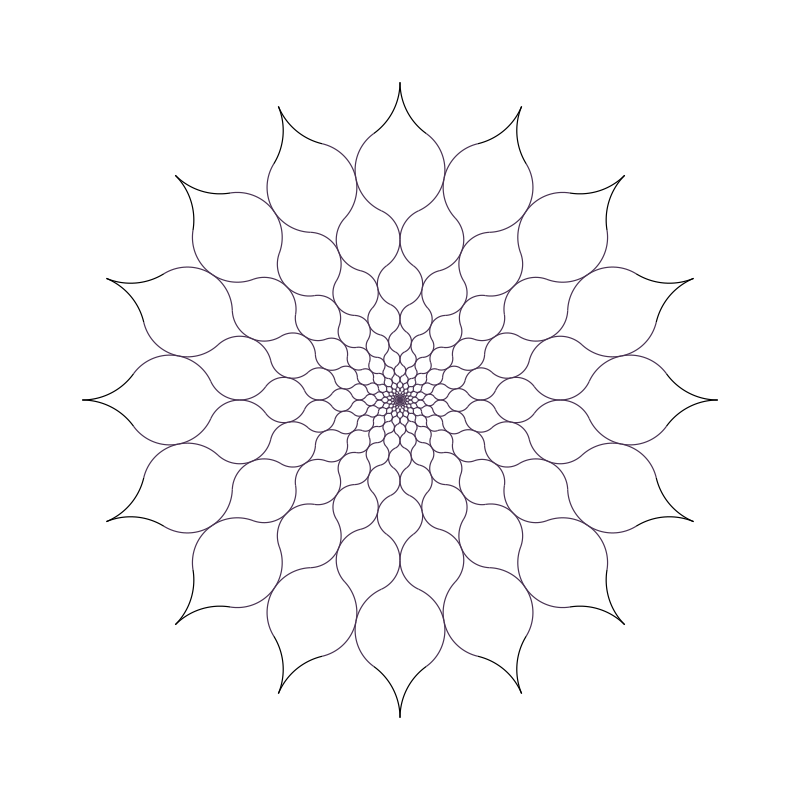

In [66]:
spiral = DoyleSpiral(p=16, q=16, t=0)
svg_data = spiral.to_svg(mode="arram_boyle", size=800)
from IPython.display import SVG, display
display(SVG(svg_data))
# Save SVG to a file
with open("doyle_spiral.svg", "w", encoding="utf-8") as f:
    f.write(svg_data)

In [7]:
import numpy as np
from pythreejs import *
import ipywidgets as widgets
from IPython.display import display
import xml.etree.ElementTree as ET

def svg_path_to_points(path_d):
    """Parse SVG path data into 3D points."""
    points = []
    commands = []
    
    # Simple parser for M and L commands
    i = 0
    while i < len(path_d):
        if path_d[i] in 'ML':
            cmd = path_d[i]
            i += 1
            # Extract coordinates
            coords = ''
            while i < len(path_d) and path_d[i] not in 'ML':
                coords += path_d[i]
                i += 1
            
            # Parse coordinates
            nums = [float(x) for x in coords.replace(',', ' ').split() if x]
            if len(nums) >= 2:
                points.append([nums[0], -nums[1], 0])  # Flip Y for proper orientation
        else:
            i += 1
    
    return np.array(points, dtype=np.float32)

def create_arc_geometry(points):
    """Create BufferGeometry from points."""
    positions = points.flatten().tolist()
    
    geometry = BufferGeometry(
        attributes={
            'position': BufferAttribute(array=positions, normalized=False, itemSize=3)
        }
    )
    return geometry

def svg_to_3d_arcs(svg_string):
    """Convert SVG string to list of 3D line objects."""
    # Parse SVG
    root = ET.fromstring(svg_string)
    
    # Find all path elements
    paths = root.findall('.//{http://www.w3.org/2000/svg}path')
    if not paths:
        paths = root.findall('.//path')  # Try without namespace
    
    arcs = []
    
    for i, path in enumerate(paths):
        d = path.get('d')
        stroke = path.get('stroke', '#483352')
        
        if d:
            points = svg_path_to_points(d)
            
            if len(points) > 1:
                geometry = create_arc_geometry(points)
                
                # Convert hex color to RGB
                color = stroke.lstrip('#')
                r, g, b = int(color[0:2], 16), int(color[2:4], 16), int(color[4:6], 16)
                color_hex = f'#{color}'
                
                material = LineBasicMaterial(
                    color='#000000',  # Black arcs
                    linewidth=3,
                    transparent=True,
                    opacity=1.0
                )
                
                line = Line(geometry=geometry, material=material)
                
                # Store metadata
                line.userData = {
                    'index': i,
                    'center': points.mean(axis=0).tolist()
                }
                
                arcs.append(line)
    
    return arcs

def create_3d_viewer(svg_string, width=800, height=600):
    """Create interactive 3D viewer for Doyle spiral."""
    
    # Parse SVG and create arcs
    arcs = svg_to_3d_arcs(svg_string)
    print(f"Loaded {len(arcs)} arcs")
    
    # Get viewBox for scaling
    root = ET.fromstring(svg_string)
    viewbox = root.get('viewBox', '-400 -400 800 800')
    # Handle both space and comma separated values
    viewbox = viewbox.replace(',', ' ')
    vx, vy, vw, vh = map(float, viewbox.split())
    
    print(f"ViewBox: {vx}, {vy}, {vw}, {vh}")
    
    # Calculate actual bounds from all arcs
    all_points = []
    for arc in arcs:
        positions = arc.geometry.attributes['position'].array
        for i in range(0, len(positions), 3):
            all_points.append([positions[i], positions[i+1], positions[i+2]])
    
    all_points = np.array(all_points)
    mins = all_points.min(axis=0)
    maxs = all_points.max(axis=0)
    
    print(f"Actual bounds: X[{mins[0]:.2f}, {maxs[0]:.2f}], Y[{mins[1]:.2f}, {maxs[1]:.2f}]")
    
    # Calculate scale to fit in a 2x2 view
    extent = max(maxs[0] - mins[0], maxs[1] - mins[1])
    scale = 1.8 / extent if extent > 0 else 1.0
    
    # Calculate center offset
    center_x = (mins[0] + maxs[0]) / 2
    center_y = (mins[1] + maxs[1]) / 2
    
    print(f"Scale: {scale:.6f}, Center: ({center_x:.2f}, {center_y:.2f})")
    
    # Create group for all arcs with proper scaling and centering
    arc_group = Group()
    
    for arc in arcs:
        arc_group.add(arc)
    
    # Apply scale and centering to the group
    arc_group.scale = (scale, scale, scale)
    arc_group.position = (-center_x * scale, -center_y * scale, 0)
    
    # Camera - move closer
    camera = PerspectiveCamera(
        position=[0, 0, 3],
        fov=75,
        aspect=width/height,
        near=0.01,
        far=100
    )
    
    # Lights - brighter for better visibility
    key_light = DirectionalLight(color='white', position=[5, 5, 5], intensity=1.5)
    fill_light = DirectionalLight(color='white', position=[-5, -3, -5], intensity=0.8)
    ambient_light = AmbientLight(intensity=1.0)
    
    # Scene with white background
    scene = Scene(
        children=[arc_group, camera, key_light, fill_light, ambient_light],
        background='#ffffff'
    )
    
    # Renderer with antialiasing
    renderer = Renderer(
        camera=camera,
        scene=scene,
        width=width,
        height=height,
        controls=[OrbitControls(controlling=camera, target=[0, 0, 0])],
        antialias=True
    )
    
    # Animation controls
    rotation_speed = widgets.FloatSlider(
        value=0.01,
        min=0,
        max=0.05,
        step=0.001,
        description='Rotation:',
        style={'description_width': '100px'}
    )
    
    animation_mode = widgets.Dropdown(
        options=['None', 'Wave', 'Pulse', 'Spiral', 'Random'],
        value='None',
        description='Animation:',
        style={'description_width': '100px'}
    )
    
    animation_speed = widgets.FloatSlider(
        value=1.0,
        min=0.1,
        max=5.0,
        step=0.1,
        description='Anim Speed:',
        style={'description_width': '100px'}
    )
    
    # Animation state
    anim_state = {'time': 0, 'playing': True}
    
    def animate(change=None):
        if not anim_state['playing']:
            return
            
        # Rotate the group (using quaternion: x, y, z, w)
        current_rotation = arc_group.rotation
        new_z_rotation = current_rotation[2] + rotation_speed.value
        arc_group.rotation = (current_rotation[0], current_rotation[1], new_z_rotation, current_rotation[3])
        
        # Apply animations to individual arcs
        if animation_mode.value != 'None':
            anim_state['time'] += 0.05 * animation_speed.value
            t = anim_state['time']
            
            for i, arc in enumerate(arcs):
                center = np.array(arc.userData['center'])
                distance = np.linalg.norm(center[:2])
                angle = np.arctan2(center[1], center[0])
                
                if animation_mode.value == 'Wave':
                    phase = distance * 0.1 - t
                    opacity = 0.3 + 0.7 * (np.sin(phase) * 0.5 + 0.5)
                    arc.material.opacity = float(opacity)
                    
                elif animation_mode.value == 'Pulse':
                    phase = i * 0.01 - t
                    opacity = 0.4 + 0.6 * (np.sin(phase) * 0.5 + 0.5)
                    arc.material.opacity = float(opacity)
                    scale_factor = 1.0 + 0.1 * np.sin(phase)
                    arc.scale = (scale_factor, scale_factor, 1.0)
                    
                elif animation_mode.value == 'Spiral':
                    phase = angle + distance * 0.05 - t
                    opacity = 0.3 + 0.7 * (np.sin(phase) * 0.5 + 0.5)
                    arc.material.opacity = float(opacity)
                    
                elif animation_mode.value == 'Random':
                    phase = np.sin(i * 0.1) * 5 - t
                    opacity = 0.2 + 0.8 * (np.sin(phase) * 0.5 + 0.5)
                    arc.material.opacity = float(opacity)
        else:
            # Reset all arcs
            for arc in arcs:
                arc.material.opacity = 1.0
                arc.scale = (1.0, 1.0, 1.0)
    
    # Set up animation loop
    from IPython.display import Javascript, display as ipy_display
    
    def start_animation():
        anim_state['playing'] = True
        # Use JavaScript to create animation loop
        js_code = """
        (function animate() {
            if (window.doyleAnimRunning) {
                IPython.notebook.kernel.execute('animate()');
                requestAnimationFrame(animate);
            }
        })();
        """
        ipy_display(Javascript("window.doyleAnimRunning = true;" + js_code))
    
    def stop_animation():
        anim_state['playing'] = False
        ipy_display(Javascript("window.doyleAnimRunning = false;"))
    
    play_button = widgets.Button(description='▶ Play', button_style='success')
    stop_button = widgets.Button(description='⏸ Pause', button_style='warning')
    
    def on_play(b):
        start_animation()
    
    def on_stop(b):
        stop_animation()
    
    play_button.on_click(on_play)
    stop_button.on_click(on_stop)
    
    # Manual animation trigger for simpler approach
    rotation_speed.observe(lambda x: None, names='value')
    animation_mode.observe(lambda x: None, names='value')
    animation_speed.observe(lambda x: None, names='value')
    
    # Create UI
    controls = widgets.VBox([
        widgets.HBox([play_button, stop_button]),
        rotation_speed,
        animation_mode,
        animation_speed
    ])
    
    display(widgets.VBox([renderer, controls]))
    
    # Return objects for manual control
    return {
        'renderer': renderer,
        'scene': scene,
        'arcs': arcs,
        'arc_group': arc_group,
        'animate': animate,
        'controls': controls
    }


# Usage in Jupyter:
# 1. Generate SVG with your existing code:
spiral = DoyleSpiral(p=16, q=16, t=0)
svg_data = spiral.to_svg(mode='arram_boyle')

# 2. Create 3D viewer:
viewer = create_3d_viewer(svg_data)

# 3. Animate manually:
for i in range(100):
     viewer['animate']()
     import time
     time.sleep(0.05)

Loaded 952 arcs
ViewBox: -400.0, -400.0, 800.0, 800.0
Actual bounds: X[-317.75, 317.75], Y[-317.75, 317.75]
Scale: 0.002832, Center: (0.00, 0.00)
